In [7]:
import os, numpy as np, rasterio
from rasterio.features import rasterize
from shapely.ops import unary_union
import geopandas as gpd
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

os.makedirs(out_dir, exist_ok=True)

In [5]:
hh_path = '/Users/kavyakomar/Documents/ISRO/E04_SAR_MRS_18JUN2025_169011402831_18445_STUC00ZTD_25052_14_DH_D_R_N20008_E070365/scene_HH/imagery_HH.tif'
inc_path   = "/Users/kavyakomar/Documents/ISRO/E04_SAR_MRS_18JUN2025_169011402831_18445_STUC00ZTD_25052_14_DH_D_R_N20008_E070365/E04_SAR_MRS_18JUN2025_169011402831_18445_STUC00ZTD_25052_14_DH_D_R_N20008_E070365_lia.tif"                
illum_path   = "/Users/kavyakomar/Documents/ISRO/E04_SAR_MRS_18JUN2025_169011402831_18445_STUC00ZTD_25052_14_DH_D_R_N20008_E070365/E04_SAR_MRS_18JUN2025_169011402831_18445_STUC00ZTD_25052_14_DH_D_R_N20008_E070365_area.tif"
coast_shp= "/Users/kavyakomar/Documents/ISRO/IND_adm/IND_adm0.shp"
subset_window = None 
out_dir="/Users/kavyakomar/Documents/ISRO/results"



In [9]:

K_BETA0_dB  = 69.265


In [11]:
with rasterio.open(hh_path) as src:
    hh   = src.read(1).astype(np.float32)
    meta = src.meta.copy()        # will reuse later
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

inc = rasterio.open(inc_path).read(1).astype(np.float32)
illum = rasterio.open(illum_path).read(1).astype(np.float32)


In [12]:
def build_water_mask(crs, transform, height, width, illum, coast_shp):
    """Return Boolean water_mask. Uses coastline shapefile if available,
       otherwise falls back to illum<1.5 rule."""
    if coast_shp and os.path.exists(coast_shp):
        land = gpd.read_file(coast_shp).to_crs(crs)
        merged = unary_union(land.geometry)
        land_mask = rasterize([(merged, 1)], out_shape=(height, width),
                              transform=transform, fill=0, dtype='uint8')
        water_mask = land_mask == 0
        print("Land masked via coastline shapefile.")
    else:
        water_mask = illum < 1.5
        print("Coastline shapefile not found – used illum<1.5 fallback.")
    return water_mask

water_mask = build_water_mask(crs, transform, height, width, illum, coast_shp)

Land masked via coastline shapefile.


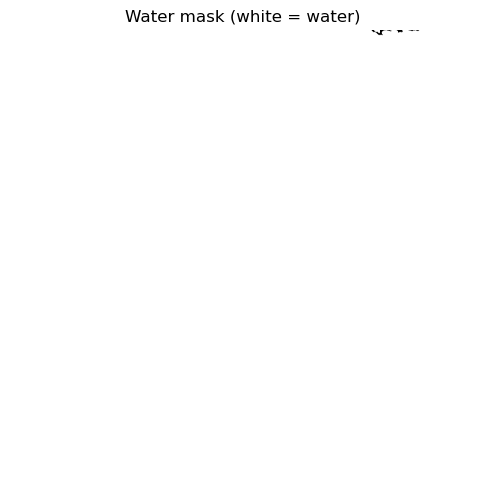

In [15]:
plt.figure(figsize=(6,6)); plt.imshow(water_mask, cmap='gray'); plt.title("Water mask (white = water)"); plt.axis('off'); plt.show()


In [17]:
kcal_db  = 69.265
kcal_lin = 10 ** (kcal_db / 10)

valid = (inc != -2) & water_mask & np.isfinite(illum) & (hh > 0)

Gamma0 = np.full_like(hh, np.nan, dtype=np.float32)
Beta0  = np.full_like(hh, np.nan, dtype=np.float32)
Sigma0 = np.full_like(hh, np.nan, dtype=np.float32)

Gamma0[valid] = (hh[valid] ** 2) / kcal_lin
Beta0[valid]  = Gamma0[valid] * illum[valid]
Sigma0[valid] = Beta0[valid]  * np.sin(np.deg2rad(inc[valid]))

Sigma0_db = np.full_like(Sigma0, np.nan, dtype=np.float32)
Sigma0_db[valid] = 10 * np.log10(np.clip(Sigma0[valid], 1e-6, None))


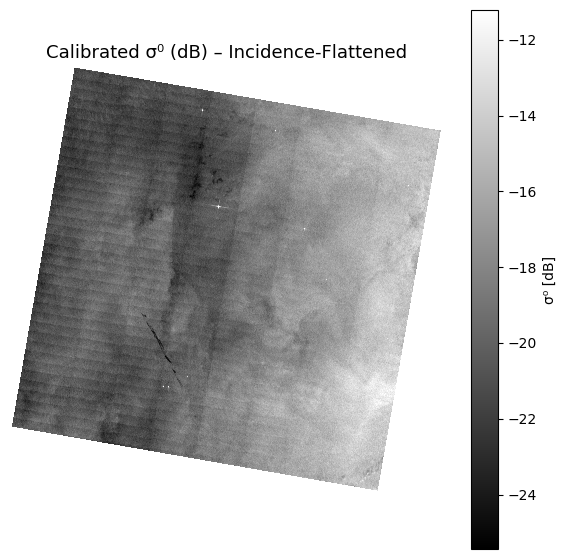

In [18]:
vmin, vmax = np.nanpercentile(Sigma0_db, [2, 98])

plt.figure(figsize=(7, 7))
plt.imshow(Sigma0_db, cmap='gray', vmin=vmin, vmax=vmax)
plt.title("Calibrated σ⁰ (dB) – Incidence-Flattened", fontsize=13)
plt.colorbar(label='σ⁰ [dB]')
plt.axis('off')
plt.show()

In [21]:
calib_path = os.path.join(out_dir, "Sigma0_water.tif")
meta.update(dtype='float32', nodata=np.nan)
with rasterio.open(calib_path, 'w', **meta) as dst:
    dst.write(Sigma0.astype(np.float32), 1)
print("Saved calibrated Sigma0:", calib_path)

Saved calibrated Sigma0: /Users/kavyakomar/Documents/ISRO/results/Sigma0_water.tif


In [23]:
def lee_filter_nan(img, size=5):
    img_fill = np.nan_to_num(img, nan=0.0)
    nanmask  = ~np.isnan(img)

    lm  = uniform_filter(img_fill, size, mode='reflect')
    cnt = uniform_filter(nanmask.astype(np.float32), size, mode='reflect')
    lm  = np.divide(lm, cnt, where=cnt!=0)

    lsq = uniform_filter(img_fill**2, size, mode='reflect')
    lsq = np.divide(lsq, cnt, where=cnt!=0)
    var = lsq - lm**2

    noise_var = np.nanmedian(var[np.isfinite(var)])
    w = np.divide(var, var + noise_var, out=np.zeros_like(var), where=(var+noise_var)!=0)
    out = lm + w*(img_fill - lm)
    out[~nanmask] = np.nan
    return out

Sigma0_filt = lee_filter_nan(Sigma0, size=5)

filt_path = os.path.join(out_dir, "Sigma0_water_Lee5x5.tif")
with rasterio.open(filt_path, 'w', **meta) as dst:
    dst.write(Sigma0_filt.astype(np.float32), 1)
print("Saved Lee‑filtered Sigma0:", filt_path)

Saved Lee‑filtered Sigma0: /Users/kavyakomar/Documents/ISRO/results/Sigma0_water_Lee5x5.tif


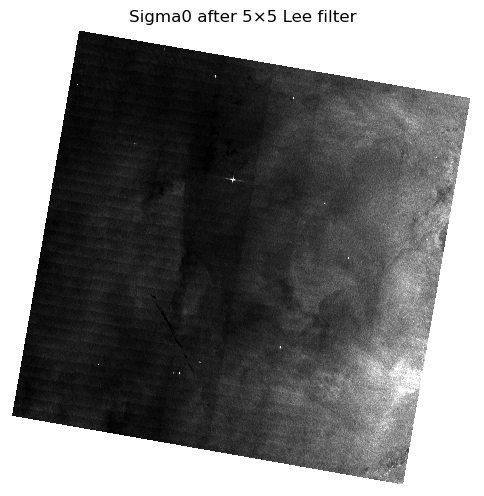

In [25]:
plt.figure(figsize=(6,6))
plt.imshow(Sigma0_filt, cmap='gray',
           vmin=np.nanpercentile(Sigma0_filt,2),
           vmax=np.nanpercentile(Sigma0_filt,98))
plt.title("Sigma0 after 5×5 Lee filter"); plt.axis('off'); plt.show()

In [27]:
from skimage.filters import threshold_local
from skimage.measure import label, regionprops

print("\nRunning adaptive thresholding...")

# 1. Replace NaNs with zero so threshold_local works
sigma_clean = np.nan_to_num(Sigma0_filt, nan=0.0)

# 2. Compute local threshold (block_size must be odd)
block_size = 31     # smaller neighbourhood
offset     = 0.2    # was 0.5 → makes threshold lower → more pixels marked dark
adaptive_thr = threshold_local(sigma_clean, block_size, offset=offset)

# 3. "Dark" pixels are slick candidates
binary_dark = sigma_clean < adaptive_thr      # True = dark region

# 4. Label connected components
label_img = label(binary_dark, connectivity=2)    # 8‑connected
regions   = regionprops(label_img, intensity_image=sigma_clean)

print(f"Total dark regions detected: {len(regions)}")


Running adaptive thresholding...
Total dark regions detected: 32


Area: 532.0 px  |  Mean Σ0: 0.18  |  Solidity: 0.864
Area: 35.0 px  |  Mean Σ0: 0.04  |  Solidity: 0.614
Area: 35.0 px  |  Mean Σ0: 0.04  |  Solidity: 0.593
Area: 13.0 px  |  Mean Σ0: 0.06  |  Solidity: 0.722
Area: 20.0 px  |  Mean Σ0: 0.05  |  Solidity: 0.645
Area: 28.0 px  |  Mean Σ0: 0.07  |  Solidity: 0.583
Area: 1.0 px  |  Mean Σ0: 0.17  |  Solidity: 1.000
Area: 3.0 px  |  Mean Σ0: 0.06  |  Solidity: 0.750
Area: 3.0 px  |  Mean Σ0: 0.08  |  Solidity: 1.000
Area: 10.0 px  |  Mean Σ0: 0.04  |  Solidity: 0.667
Area: 1.0 px  |  Mean Σ0: 0.04  |  Solidity: 1.000
Area: 384.0 px  |  Mean Σ0: 0.11  |  Solidity: 0.857
Area: 3.0 px  |  Mean Σ0: 0.04  |  Solidity: 1.000
Area: 1.0 px  |  Mean Σ0: 0.03  |  Solidity: 1.000
Area: 1070.0 px  |  Mean Σ0: 1.19  |  Solidity: 0.871
Area: 421.0 px  |  Mean Σ0: 0.13  |  Solidity: 0.844
Area: 12.0 px  |  Mean Σ0: 0.05  |  Solidity: 0.923
Area: 13.0 px  |  Mean Σ0: 0.06  |  Solidity: 0.867
Area: 12.0 px  |  Mean Σ0: 0.05  |  Solidity: 0.750
Area: 9.0 px 

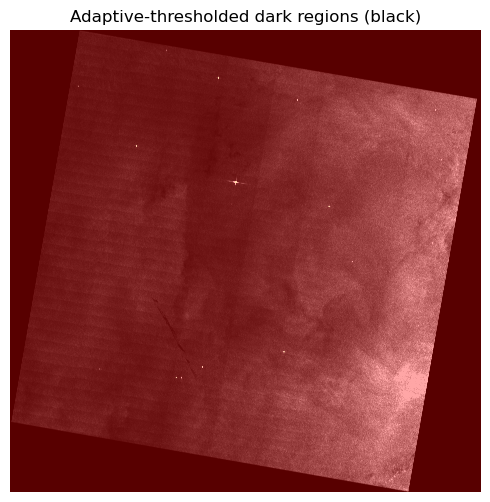

Saved adaptive‑threshold binary mask: /Users/kavyakomar/Documents/ISRO/results/slick_candidates_binary.tif


In [32]:
for r in regions:
    print(f"Area: {r.area} px  |  Mean Σ0: {r.mean_intensity:.2f}  |  Solidity: {r.solidity:.3f}")

# 6. Visualise
plt.figure(figsize=(8,6))
plt.imshow(sigma_clean, cmap='gray',
           vmin=np.nanpercentile(sigma_clean,2),
           vmax=np.nanpercentile(sigma_clean,98))
plt.imshow(binary_dark, cmap='autumn', alpha=0.35)   # red overlay for slicks
plt.title("Adaptive‑thresholded dark regions (black)")
plt.axis('off')
plt.show()

# 7. (Optional) save binary mask as GeoTIFF for GIS use
bin_meta = meta.copy()
bin_meta.update(dtype='uint8', nodata=0)
binary_path = os.path.join(out_dir, "slick_candidates_binary.tif")

with rasterio.open(binary_path, 'w', **bin_meta) as dst:
    dst.write(binary_dark.astype('uint8'), 1)

print("Saved adaptive‑threshold binary mask:", binary_path)

In [29]:
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_opening, disk
from matplotlib import cm


min_area     = 50    # px 
open_radius  = 2     # px   ← morphological opening radius

# remove isolated tiny objects
mask_clean = remove_small_objects(binary_dark, min_size=min_area)

# remove very thin noise with morphological opening
mask_clean = binary_opening(mask_clean, footprint=disk(open_radius))


# Label again after cleaning
label_img   = label(mask_clean, connectivity=2)
regions_fin = regionprops(label_img, intensity_image=sigma_clean)

print(f"\nFinal retained regions: {len(regions_fin)}")


Final retained regions: 7


In [31]:
print("Pixels in each step:")
print(" - binary_dark   :", np.count_nonzero(binary_dark))
print(" - mask_clean    :", np.count_nonzero(mask_clean))

binary_final = mask_clean.astype('uint8')
print(" - binary_final  :", np.count_nonzero(binary_final))

label_img = label(binary_final, connectivity=2)
print(" - Total regions :", label_img.max())


Pixels in each step:
 - binary_dark   : 3614
 - mask_clean    : 3162
 - binary_final  : 3162
 - Total regions : 7


In [33]:
binary_final = mask_clean.astype('uint8')   # 1 = spill, 0 = background

# Save GeoTIFF
binary_meta = meta.copy()
binary_meta.update(dtype='uint8', nodata=0)
bin_out = os.path.join(out_dir, "oil_spill_binary_mask.tif")
with rasterio.open(bin_out, 'w', **binary_meta) as dst:
    dst.write(binary_final, 1)
print("Binary spill mask saved →", bin_out)

Binary spill mask saved → /Users/kavyakomar/Documents/ISRO/results/oil_spill_binary_mask.tif


In [35]:
overlay = np.zeros((*binary_final.shape, 3), dtype='uint8')

# use a perceptually uniform colormap to colour blobs
from matplotlib.colors import Normalize
cmap = plt.colormaps['turbo']
norm = Normalize(vmin=0, vmax=len(regions_fin))
for idx, r in enumerate(regions_fin, start=0):
    colour = (np.array(cmap(norm(idx)))[:3] * 255).astype('uint8')

    coords = r.coords
    overlay[coords[:,0], coords[:,1], :] = colour

# Save PNG
overlay_path = os.path.join(out_dir, "oil_spill_colour_overlay.png")
plt.imsave(overlay_path, overlay)
print("Colour overlay saved →", overlay_path)

Colour overlay saved → /Users/kavyakomar/Documents/ISRO/results/oil_spill_colour_overlay.png


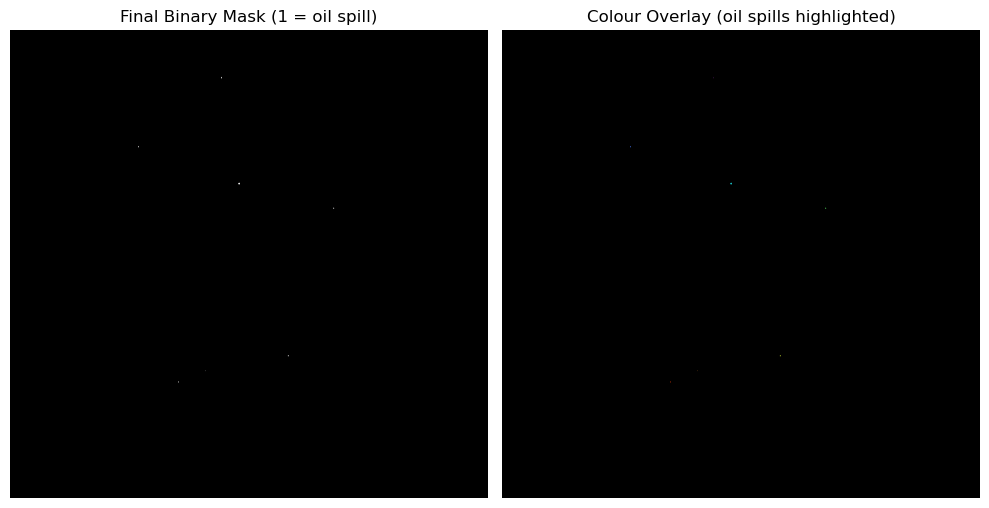

In [341]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(binary_final, cmap='gray')
plt.title("Final Binary Mask (1 = oil spill)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Colour Overlay (oil spills highlighted)")
plt.axis('off')

plt.tight_layout(); plt.show()

In [343]:
from shapely.geometry import Polygon
from skimage.measure import label, regionprops
import numpy as np
import rasterio

polys = []

rows_cols_lbl = label(mask_clean)          

for r in regionprops(rows_cols_lbl, intensity_image=sigma_clean):
    if r.area < min_area:
        continue

    rows, cols = r.coords.T

    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

    poly = Polygon(np.column_stack((xs, ys)))
    polys.append(poly)

print(f"Generated {len(polys)} polygons")


Generated 7 polygons


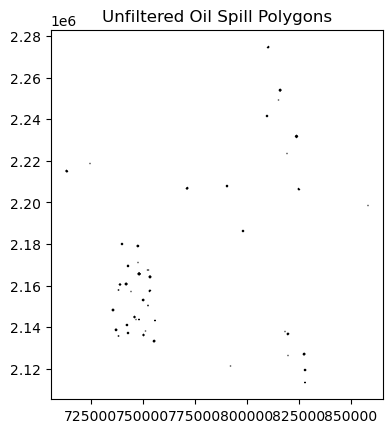

In [345]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("/Users/kavyakomar/Documents/ISRO/results/oil_spill_polygons_unfiltered.gpkg")

gdf.plot(edgecolor='black', facecolor='cyan')
plt.title("Unfiltered Oil Spill Polygons")
plt.show()


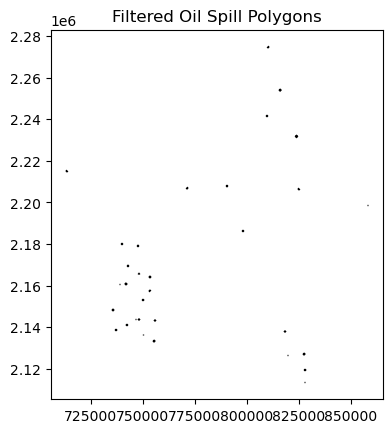

In [347]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load filtered polygons
gdf = gpd.read_file("/Users/kavyakomar/Documents/ISRO/results/oil_spill_polygons_filtered.gpkg")

# Plot
gdf.plot(edgecolor='black', facecolor='cyan')
plt.title("Filtered Oil Spill Polygons")
plt.show()


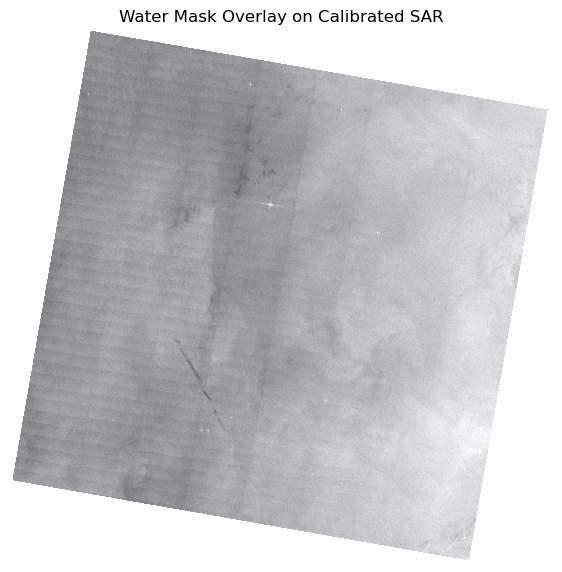

In [349]:
plt.figure(figsize=(7, 7))

# Background image (e.g., SAR backscatter in dB)
plt.imshow(Sigma0_db, cmap='gray',
           vmin=np.nanpercentile(Sigma0_db, 2),
           vmax=np.nanpercentile(Sigma0_db, 98))

# Overlay water mask in blue (semi-transparent)
plt.imshow(np.where(water_mask, 1, np.nan), cmap='Blues', alpha=0.4)

plt.title("Water Mask Overlay on Calibrated SAR")
plt.axis('off')
plt.show()
